In [1]:
%matplotlib inline

from __future__ import division, print_function

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython

import SHS_data
import util
import paired_data

import learn
reload(learn)

<module 'learn' from 'learn.pyc'>

## Learning cover song fingerprints

This notebook contains experiments in which a fingerprint is learned from a dataset of cover songs. The main idea behind this is explained in our [Audio Bigrams](http://dspace.library.uu.nl/handle/1874/314940) paper [1].

Very briefly explained:

1. most fingerprints encode some kind of co-occurrence of salient events (e.g., Shazam, 'Intervalgram')
2. 'salient event detection' can be implemented as a convolution:
        conv2d(X, W)
    with `W` the 'salient events'.
3. co-occurrence can be implemented as
        conv2d(X, w) @ X.T
   with `w` a window and `@` the matrix product.
4. all of this is differentiable, therefore, any fingerprinting system that can be formulated like this can be trained 'end-to-end'.

To evaluate the learned fingerprint, we compare to the state-of-the-art '2D Fourier Transform Magniture Coeffients' by Bertin-Mahieux and Ellis [2], and a simpler fingerprinting approach by Kim et al [3].

We use the [Second-hand Song Dataset](http://labrosa.ee.columbia.edu/millionsong/secondhand) with dublicates removed as proposed by [Julien Osmalskyj](http://www.montefiore.ulg.ac.be/~josmalskyj/code.php).

[1] Van Balen, J., Wiering, F., & Veltkamp, R. (2015). [Audio Bigrams as a Unifying Model of Pitch-based Song Description](http://dspace.library.uu.nl/handle/1874/314940).

[2] Bertin-Mahieux, T., & Ellis, D. P. W. (2012). [Large-Scale Cover Song Recognition Using The 2d Fourier Transform Magnitude.](http://academiccommons.columbia.edu/download/fedora_content/download/ac:159481/CONTENT/BertE12-2DFTM.pdf) In Proc. International Society for Music Information Retrieval Conference.

[3] Kim, S., Unal, E., & Narayanan, S. (2008). [Music fingerprint extraction for classical music cover song identification.](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=4607671&url=http%3A%2F%2Fieeexplore.ieee.org%2Fxpls%2Fabs_all.jsp%3Farnumber%3D4607671) IEEE Conference on Multimedia and Expo.



### Training data

In [2]:
n_patches, patch_len = 8, 64

In [3]:
# train, test, validation split
ratio = (50,20,30)
clique_dict, _ = SHS_data.read_cliques()
train_cliques, test_cliques_big, _ = util.split_train_test_validation(clique_dict, ratio=ratio)

# preload training data to memory (just about doable)
print('Preloading training data...')
train_uris = util.uris_from_clique_dict(train_cliques)
chroma_dict = SHS_data.preload_chroma(train_uris)

# make a training dataset of cover and non-cover pairs of songs
print('Preparing training dataset...')
X_A, X_B, Y, pair_uris = paired_data.dataset_of_pairs(train_cliques, chroma_dict,
                                                             n_patches=n_patches, patch_len=patch_len)
print('    Training set:', X_A.shape, X_B.shape, Y.shape)

Preloading training data...
Preparing training dataset...
    Training set: (32436, 512, 12) (32436, 512, 12) (32436,)


### Test data

For now, load just a small part of the test set that we'll evaluate at every iteration, e.g., a few times batch size

In [4]:
# pick a test subset
n_test_cliques = 50  # e.g., 50 ~ small actual datasets
test_cliques = {uri: test_cliques_big[uri] for uri in test_cliques_big.keys()[:n_test_cliques]}

# preload test data to memory (just about doable)
print('Preloading test data...')
test_uris = util.uris_from_clique_dict(test_cliques)
chroma_dict_T = SHS_data.preload_chroma(test_uris)

# make a test dataset of cover and non-cover pairs of songs
print('Preparing test dataset...')
X_A_T, X_B_T, Y_T, test_pair_uris_T = paired_data.dataset_of_pairs(test_cliques, chroma_dict_T,
                                                         n_patches=n_patches, patch_len=patch_len)
print('    Test set:', X_A_T.shape, X_B_T.shape, Y_T.shape)

Preloading test data...
Preparing test dataset...
    Test set: (340, 512, 12) (340, 512, 12) (340,)


### Network

Set up a siamese network.

In [27]:
# for repeated runs with different networks
tf.reset_default_graph()

In [28]:
# make network
network = learn.siamese_network(input_shape=(n_patches*patch_len, 12))
network.add_conv_layer(shape=(1,12), n_filters=12, padding='VALID')
network.add_matmul_layer(filter_len=12, n_filters=12)

### Training

Set training parameters and run for `n_epoque` iterations.
Current implementation requires an 'interactive session'.

In [29]:
alpha = 4
m = 10
lr = 3e-4
batch_size = 100
n_iterations = 3200  # 3200 ~ 10 epoques (train set ~ 320 x 100)

# training metrics
loss, pair_loss, non_pair_loss = network.loss(m=m, alpha=alpha)
bhatt, d_pairs, d_non_pairs = network.bhattacharyya()

# optimiser
train_step = network.train_step(loss, learning_rate=lr)

# choose which metrics to log
metrics = [loss, d_pairs, d_non_pairs]

In [30]:
# start Tensorflow session
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x128ae8190>> ignored


In [31]:
# train and test batches
train_batches = learn.get_batches([X_A, X_B, Y], batch_size=batch_size)
test_batch = [X_A_T, X_B_T, Y_T]

# train
for step in range(n_iterations):  
    train_batch = next(train_batches)
    
    # report
    network.log_errors(sess, train_batch=train_batch,
                       test_batch=test_batch, metrics=metrics, log_every=10)
    
    # train
    train_feed = {network.x_A:train_batch[0], network.x_B:train_batch[1],
                  network.is_cover:train_batch[2]}
    train_step.run(feed_dict=train_feed)
    
# report final
network.log_errors(sess, train_batch=train_batch,
                   test_batch=test_batch, metrics=metrics)

   TR.loss TR.d_pairs TR.d_non_pairs  TE.loss TE.d_pairs TE.d_non_pairs
0  43.5403    5.11521        7.30174  45.6209    6.25334        7.82205 

    TR.loss TR.d_pairs TR.d_non_pairs TE.loss TE.d_pairs TE.d_non_pairs
10  46.2566    6.48997        8.09015  43.449    6.51223        8.19473 

    TR.loss TR.d_pairs TR.d_non_pairs  TE.loss TE.d_pairs TE.d_non_pairs
20  43.6188    6.93647        8.16343  42.1766    6.66544        8.40268 

    TR.loss TR.d_pairs TR.d_non_pairs  TE.loss TE.d_pairs TE.d_non_pairs
30  37.6923    6.75306        8.96504  41.2071     6.7171        8.46571 

   TR.loss TR.d_pairs TR.d_non_pairs TE.loss TE.d_pairs TE.d_non_pairs
40  53.201     8.2057        7.94933  40.528    6.71458        8.45561 

   TR.loss TR.d_pairs TR.d_non_pairs  TE.loss TE.d_pairs TE.d_non_pairs
50  39.752    6.95889        8.67382  40.0099    6.75888        8.50724 

    TR.loss TR.d_pairs TR.d_non_pairs  TE.loss TE.d_pairs TE.d_non_pairs
60  41.5869    7.03172        8.21864  39.6046   

### Plot train and test outcome

#### loss functions

Note that training loss fluctuates much more as it's computed for a different batch at every step, while test error is (currently) computed for the same (slightly larger) subset at every step.

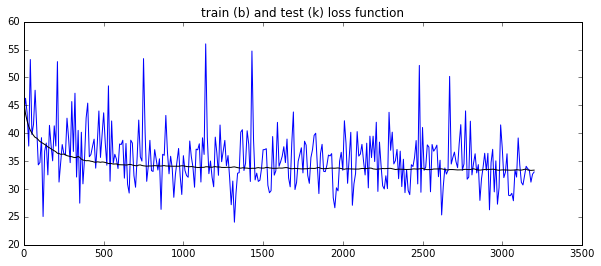

In [32]:
plt.figure(figsize=(10,4))
plt.plot(network.train_log['TR.loss']);
plt.plot(network.train_log['TE.loss'], color='k');
plt.title('train (b) and test (k) loss function');

#### distances

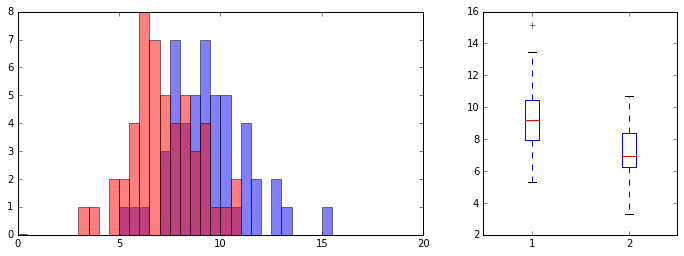

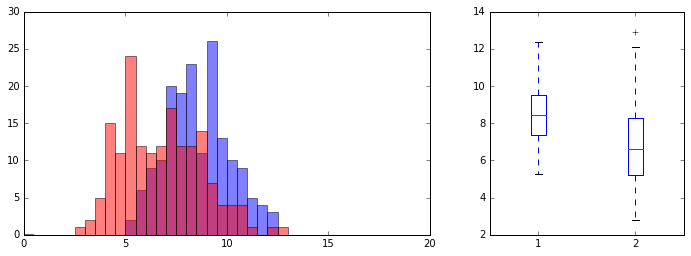

In [33]:
def plot_distances(feed):
    y_A, y_B = sess.run([network.subnet_A[-1], network.subnet_B[-1]],
                                  feed_dict=feed)
    is_cover = feed[network.is_cover]

    pair_dists = np.sqrt(np.sum((y_A - y_B)**2, axis=1))[np.where(is_cover==1)]
    non_pair_dists = np.sqrt(np.sum((y_A - y_B)**2, axis=1))[np.where(is_cover==0)]

    bins = np.arange(0,20,0.5)
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.hist(non_pair_dists, bins=bins, alpha=0.5);
    plt.hist(pair_dists, bins=bins, color='r', alpha=0.5);
    plt.subplot(143)
    plt.boxplot([non_pair_dists, pair_dists]);
    
# train distances
train_feed = {network.x_A:train_batch[0], network.x_B:train_batch[1], network.is_cover: train_batch[2]}
plot_distances(train_feed)

# test distances
test_feed = {network.x_A: X_A_T, network.x_B: X_B_T, network.is_cover: Y_T}
plot_distances(test_feed)

### Test fingerprint

Test the learned fingerprint and compare to other impelementations.

In [34]:
import main
import fingerprints as fp

In [35]:
def fingerprint(chroma, n_patches=8, patch_len=64):
    n_frames, n_bins = chroma.shape
    if not n_frames == n_patches * patch_len:
        chroma = paired_data.patchwork(chroma, n_patches=n_patches,
                                       patch_len=patch_len)
    fps = []
    for i in range(12):
        chroma_trans = np.roll(chroma, -i, axis=1)
        chroma_tensor = chroma_trans.reshape((1, n_patches*patch_len, 12))
        network_out = network.subnet_A[-1]
        fp = network_out.eval(feed_dict={network.x_A : chroma_tensor})
        fps.append(fp.flatten())
    return fps

#### covariance-based fingerprint

Kim, S., Unal, E., & Narayanan, S. (2008). Music fingerprint extraction for classical music cover song identification.
IEEE Conference on Multimedia and Expo.

`test_cliques_big`:

    results: {'mean r5': 0.073941374228151044, 'mean ap': 0.069848998736677395, 'mean p1': 0.097366977509599564}

In [36]:
results = main.run_leave_one_out_experiment(test_cliques_big,
                                            fp_function=fp.cov,
                                            print_every=50)
print('results:', results)

Computing fingerprints...
    Fingerprinting track 50/3646...
    Fingerprinting track 100/3646...
    Fingerprinting track 150/3646...
    Fingerprinting track 200/3646...
    Fingerprinting track 250/3646...
    Fingerprinting track 300/3646...
    Fingerprinting track 350/3646...
    Fingerprinting track 400/3646...
    Fingerprinting track 450/3646...
    Fingerprinting track 500/3646...
    Fingerprinting track 550/3646...
    Fingerprinting track 600/3646...
    Fingerprinting track 650/3646...
    Fingerprinting track 700/3646...
    Fingerprinting track 750/3646...
    Fingerprinting track 800/3646...
    Fingerprinting track 850/3646...
    Fingerprinting track 900/3646...
    Fingerprinting track 950/3646...
    Fingerprinting track 1000/3646...
    Fingerprinting track 1050/3646...
    Fingerprinting track 1100/3646...
    Fingerprinting track 1150/3646...
    Fingerprinting track 1200/3646...
    Fingerprinting track 1250/3646...
    Fingerprinting track 1300/3646...
    Fi

#### 2d-DFT-based fingerprint

Bertin-Mahieux, T., & Ellis, D. P. W. (2012). Large-Scale Cover Song Recognition Using The 2d Fourier Transform Magnitude. In Proc. International Society for Music Information Retrieval Conference.

The PCA step at the end of the algorithm is not implemented at the moment. Without PCA, a patch length of 64 was found to be better than the original 75, and mean pooling across patches worked better than median-pooling, so these parameters were used instead. The difference between PCA and no PCA performance on a 12K test set was 0.08912 vs. 0.09475 mean average precision, or about 6%.

`test_cliques_big`:

    results: {'mean r5': 0.11885786185784572, 'mean ap': 0.11072061679198177, 'mean p1': 0.14070213933077344}

In [37]:
results = main.run_leave_one_out_experiment(test_cliques_big,
                                            fp_function=fp.fourier,
                                            print_every=50)
print('results:', results)

Computing fingerprints...
    Fingerprinting track 50/3646...
    Fingerprinting track 100/3646...
    Fingerprinting track 150/3646...
    Fingerprinting track 200/3646...
    Fingerprinting track 250/3646...
    Fingerprinting track 300/3646...
    Fingerprinting track 350/3646...
    Fingerprinting track 400/3646...
    Fingerprinting track 450/3646...
    Fingerprinting track 500/3646...
    Fingerprinting track 550/3646...
    Fingerprinting track 600/3646...
    Fingerprinting track 650/3646...
    Fingerprinting track 700/3646...
    Fingerprinting track 750/3646...
    Fingerprinting track 800/3646...
    Fingerprinting track 850/3646...
    Fingerprinting track 900/3646...
    Fingerprinting track 950/3646...
    Fingerprinting track 1000/3646...
    Fingerprinting track 1050/3646...
    Fingerprinting track 1100/3646...
    Fingerprinting track 1150/3646...
    Fingerprinting track 1200/3646...
    Fingerprinting track 1250/3646...
    Fingerprinting track 1300/3646...
    Fi

#### learned fingerprint

We now see that with the right configuration, we are able to make the fingerprinter do a little bit better than the 2d-DFT-based fingerprints:

`test_cliques_big` with `W_1 = 12x12` and `W_2 = 12x12`.

    fp_results: {'mean r5': 0.13775251746235256, 'mean ap': 0.12335753431869072, 'mean p1': 0.15551289083927591}

In [38]:
results = main.run_leave_one_out_experiment(test_cliques_big,
                                            fp_function=fingerprint,
                                            print_every=50)
print('fp_results:', results)

Computing fingerprints...
    Fingerprinting track 50/3646...
    Fingerprinting track 100/3646...
    Fingerprinting track 150/3646...
    Fingerprinting track 200/3646...
    Fingerprinting track 250/3646...
    Fingerprinting track 300/3646...
    Fingerprinting track 350/3646...
    Fingerprinting track 400/3646...
    Fingerprinting track 450/3646...
    Fingerprinting track 500/3646...
    Fingerprinting track 550/3646...
    Fingerprinting track 600/3646...
    Fingerprinting track 650/3646...
    Fingerprinting track 700/3646...
    Fingerprinting track 750/3646...
    Fingerprinting track 800/3646...
    Fingerprinting track 850/3646...
    Fingerprinting track 900/3646...
    Fingerprinting track 950/3646...
    Fingerprinting track 1000/3646...
    Fingerprinting track 1050/3646...
    Fingerprinting track 1100/3646...
    Fingerprinting track 1150/3646...
    Fingerprinting track 1200/3646...
    Fingerprinting track 1250/3646...
    Fingerprinting track 1300/3646...
    Fi